# MEFE - TP computacional 3

**Tomás Di Napoli**

Este trabajo es la resolución del tercer TP computacional de [MEFE](http://materias.df.uba.ar/meefea2023c1/), cuya consigna se puede ver [acá](http://materias.df.uba.ar/meefea2023c1/files/2012/07/Test_de_Hip%C3%B3tesis_MEFE_2023_Madres21.pdf). También tiene su versión en [Jupyter Notebook]() junto con otros ejercicios de la materia que estoy subiendo a [este](https://github.com/tdinapoli/mefe/) repositorio de github.

Primero que nada importo las librerías que voy a usar y configuro el estilo de los gráficos

In [1]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import scipy.stats as ss
plt.style.use('seaborn')
mpl.rcParams['figure.dpi'] = 200
mpl.rcParams['legend.fontsize'] = 15
mpl.rcParams['axes.labelsize'] = 15
mpl.rcParams['xtick.labelsize'] = 10
mpl.rcParams['ytick.labelsize'] = 10

## Introducción

El problema consiste en determinar si la cantidad de hijas que tienen las levaduras por unidad de tiempo es constante o no en el tiempo. Sin embargo, en el experimento que proponen no se puede medir esto directamente sino que contamos con un chip de microfluídica que nos permite contar cantidad de hijas que tiene una levadura a lo largo de toda su vida.

Por suerte sabemos que la distribución de probabilidad que describe la cantidad de hijas que tiene una levadura hasta que muere está dada por la distribución de *Weibull*
$$Weibull(x \mid \lambda, \alpha) = \lambda \alpha (\lambda x)^{\alpha - 1} e^{-(\lambda x)^\alpha},$$
y que el valor de $\alpha = 1$ se asocia a una tasa de nacimientos constante en el tiempo.

Más específicamente (y por algún motivo extraño) queremos distinguir, dada la medición de cuántas hijas tuvieron varias levaduras durante su vida, si provienen de una distribución de *Weibull* con $\lambda = 1/30$ y $\alpha = 1$ (tasa de nacimientos constante en el tiempo) o de una con $\lambda = 1/30$ y $\alpha = 0.8$ (tasa decreciente en el tiempo). Enunciado el problema podemos identificar la hipótesis nula $H_0$ y la hipótesis alternativa $H_1$:

- **$H_0$**: Las levaduras provienen de una distribución de $Weibull(x \mid \lambda = 1/30, \alpha_0 = 1)$.
- **$H_1$**: Las levaduras provienen de una distribución de $Weibull(x \mid \lambda = 1/30, \alpha_1 = 0.8)$.

Es importante notar que **ambas hipótesis son simples**, es decir que las poblaciones asociadas a cada hipótesis están fijas a una distribución de probabilidad completamente definida, sin grados de libertad. Para mi no tiene sentido hacer un test de este estilo en este caso, porque la hipótesis nula $H_0$ tiene un significado concreto (la tasa de nacimientos es constante) mientras que el valor de $\alpha = 0.8$ parece tomado arbitrariamente. Si lo que se quisiera probar es que la tasa es constante entonces habría que comparar $\alpha = 1$ como hipótesis nula contra $\alpha \neq 1$ como hipótesis alternativa, la cuál dejaría de ser simple en este caso. 

Reemplazando para los valores particulares de cada hipótesis, las distribuciones correspondientes quedan

$$W_0(x \mid \lambda = 1/30, \alpha = 1) = \frac{e^{(-\frac{x}{30})}}{30}$$
$$W_1(x \mid \lambda = 1/30, \alpha = 0.8) = \frac{4}{150} \left( \frac{4x}{150} \right)^{-1/5} e^{-(\frac{x}{30})^{4/5}}$$

Bueno, me callo y arranco con los problemas.

## Ganando intuición
#### Problemas 1 y 2

Me piden generar 100 realizaciones de variables aleatorias correspondientes a cada una de las hipótesis. Para eso primero defino los parámetros del problema y creo las variables aleatorias

In [2]:
# Defino los parámetros
lmbd = 1/30
alpha0 = 1
alpha1 = 0.8
# Creo las variables aleatorias (por cómo está 
# definido debo poner 1/lambda en la escala)
wbc = ss.weibull_min(alpha0, scale=1/lmbd, loc=0)
wbd = ss.weibull_min(alpha1, scale=1/lmbd, loc=0)

Genero dos muestras de 100 mediciones de cada una de las variables aleatorias.

In [3]:
# Genero muestras de 100 datos de cada distribución
samplec = wbc.rvs(size=100)
sampled = wbd.rvs(size=100)

Ahora grafico los histogramas de las variables aleatorias, y para ganar más intuición también sus PDF entre los valores de $x$ para los cuales la cdf es 0.01 y 0.99.

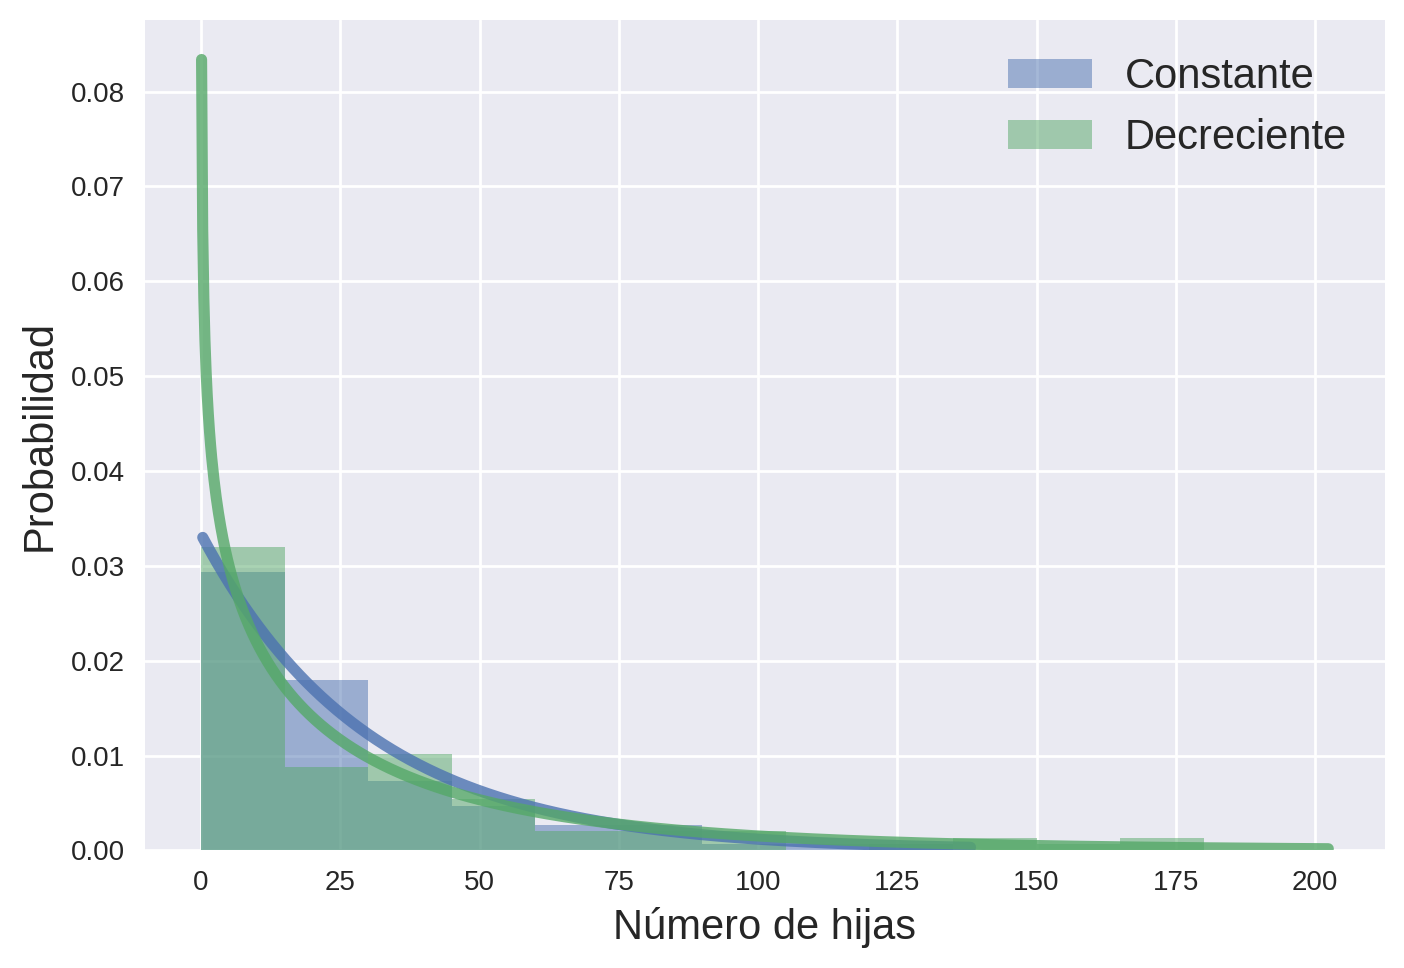

In [4]:
# Genero los x para graficar
x1 = np.linspace(wbc.ppf(0.01), wbc.ppf(0.99), 1000)
x2 = np.linspace(wbd.ppf(0.01), wbd.ppf(0.99), 1000)

# Grafico los histogramas normalizados
bins = np.arange(0, 201, 15, dtype=int)
def plot():
    freq, bin_edges = np.histogram(samplec, density=True, bins=bins)
    plt.stairs(freq, bin_edges, fill=True, alpha=0.5,
               color="C0", label="Constante")
    freq, bin_edges = np.histogram(sampled, density=True, bins=bins)
    plt.stairs(freq, bin_edges, fill=True, alpha=0.5,
               color="C1", label="Decreciente")

    # Grafico las distribuciones sobre los histogramas.
    plt.plot(x1, wbc.pdf(x1), lw=4, alpha=0.8, color="C0")
    plt.plot(x2, wbd.pdf(x2), lw=4, alpha=0.8, color="C1")
    plt.legend()
    plt.xlabel("Número de hijas")
    plt.ylabel("Probabilidad")
plot()
plt.show()

Al ser exponenciales, quizás es mejor visualizar esto con escala logarítmica en el eje y. Repito todo pero pongo plt.yscale("log") al final.

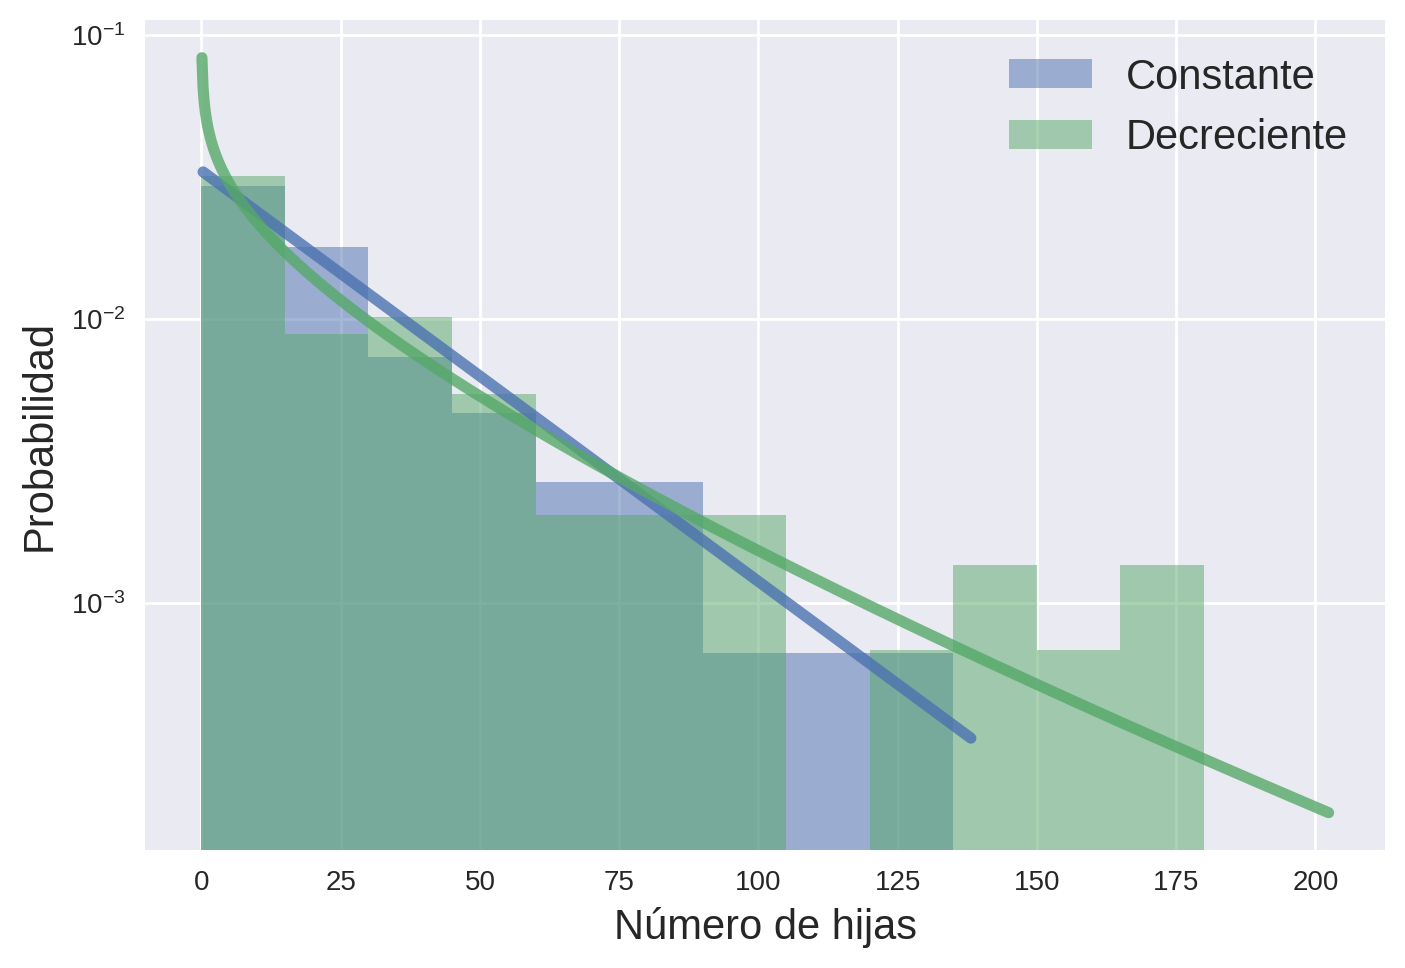

In [5]:
plot()
plt.yscale("log")
plt.show()

## El estadístico y el test
#### Problemas 3 y 4

Como las hipótesis que tenemos son ambas simples, podemos hacer uso del [*lema de Neyman-Pearson*](https://www.youtube.com/watch?v=j84yWGAp3-8), que dice que para una dada significancia definida (es decir, error de tipo 1, en este caso $\alpha = 0.05$) la región de rechazo $R$ que maximiza el poder del test está dada por

$$R = \left\{ \mathbf{x} : \frac{\mathcal{L}( \mathbf{x} \mid \alpha_1)}{\mathcal{L}(\mathbf{x} \mid \alpha_0)} > k \right\},$$

donde $\mathbf{x}$ es el vector de las $n$ mediciones, $\mathcal{L}(\mathbf{x} \mid \alpha_0)$ y $\mathcal{L}(\mathbf{x} \mid \alpha_1)$ son las verosimilitudes de las hipótesis $H_0$ y $H_1$ respectivamente, y $k$ es la constante que hace que se cumpla que la región de rechazo sea tal que

$$\alpha = \int_R \mathcal{L}(\mathbf{x} \mid \alpha_0) d\mathbf{x}.$$

Es decir, este lema nos permite elegir el test que minimiza el error de tipo 2 para un error de tipo 1 definido por nosotros. Esto se puede hacer de forma sistemática sólo cuando las dos hipótesis que se comparan son simples.

Ahora, un problema es que la desigualdad que define la región de rechazo $R$ (EQ) es $n$-dimensional. Para resolver esto puedo escribirla explícitamente y definir el estadístico $t(\mathbf{x})$ adecuado para que la desigualdad sea simplemente la diferencia entre dos números. Lo hago con parámetros arbitrarios $\lambda_0$, $\lambda_1$, $\alpha_0$ y $\alpha_1$ y luego reemplazo:

$$
\begin{align*}
\frac{\mathcal{L}( \mathbf{x} \mid \alpha_1)}{\mathcal{L}(\mathbf{x} \mid \alpha_0)} &= \prod_{i=1}^n \frac{\lambda_1 \alpha_1 (\lambda_1 x_i)^{\alpha_1 - 1} \exp{[(\lambda_1 x_i)^{\alpha_1}]}}{\lambda_0 \alpha_0 (\lambda_0 x_i)^{\alpha_0 - 1} \exp{[(\lambda_0 x_i)^{\alpha_0}]}} \\
&= \left( \frac{\alpha_1 \lambda_1^{\alpha_1}}{\alpha_0 \lambda_0^{\alpha_0}} \right)^n \exp\left(  \sum_i^n \left[ (\lambda_0 x_i)^{\alpha_0} - (\lambda_1 x_i)^{\alpha_1} \right]  \right) \prod_i^n \exp{((\alpha_1 - \alpha_0)\ln (x_i) )} \\
&= \left( \frac{\alpha_1 \lambda_1^{\alpha_1}}{\alpha_0 \lambda_0^{\alpha_0}} \right)^n \exp\left(  \sum_i^n \left[ (\lambda_0 x_i)^{\alpha_0} - (\lambda_1 x_i)^{\alpha_1}  + (\alpha_1 - \alpha_0) \ln(x_i) \right] \right)
\end{align*}
$$

lo que sugiere definir el estadístico 

$$t = \frac{1}{n} \sum_i^n \left[ (\lambda_0 x_i)^{\alpha_0} - (\lambda_1 x_i)^{\alpha_1}  + (\alpha_1 - \alpha_0) \ln(x_i) \right]$$

por lo que la condición de la región de rechazo quedaría 

$$
\begin{align*}
\left( \frac{\alpha_1 \lambda_1^{\alpha_1}}{\alpha_0 \lambda_0^{\alpha_0}} \right)^n e^{nt} &> k \\
\implies t &> - \ln \left[ \frac{\alpha_1 \lambda_1^{\alpha_1}}{\alpha_0 \lambda_0^{\alpha_0}} k^{-\frac{1}{n}} \right] \equiv t_C(n),
\end{align*}
$$

que ahora si es unidimensional. Reemplazando por los valores que tenemos para $\lambda_0 = \lambda_1 = 1/30$, $\alpha_0 = 1$ y $\alpha_1 = 4/5$ es estadístico y la desigualdad quedan

$$t = \frac{1}{n} \sum_i^n \frac{x_i}{30} - \left( \frac{x_i}{30} \right)^{4/5} - \frac{1}{5} \ln (x_i)$$

$$t > - \ln \left[ \frac{4}{5} (30)^{1/5} k^{-1/n} \right].$$

La distribución del estadístico tanto cuando $H_0$ como cuando $H_1$ es difícil de obtener analíticamente, pero gracias a Gauss y el teorema central del límite, y a que estamos usando muestras de 100 mediciones, $t$ es la suma de 100 variables aleatorias, por lo que la distribución de $t$ debe ser la normal. No puedo obtener el valor medio ni la varianza de esta normal de forma analítica, pero si de forma numérica. 

Para esto, primero defino una función que calcula mi estadístico a partir de una muestra y los parámetros necesarios


In [6]:
def estadistico(sample, lmbd, alpha0, alpha1):
    t = (lmbd*sample)**alpha0 - (lmbd*sample)**alpha1 + (alpha1 - alpha0) * np.log(sample)
    return np.sum(t)/len(t)

Luego, genero cienmil realizaciones de mi estadístico usando los parámetros de ambas hipótesis tanto para el caso en el que $H_0$ es cierta como para el caso en el que $H_1$ es cierta. 

In [7]:
N = 100000
# Caso en el que H0 es cierta (los datos provienen de weibull con alpha = 1)
t_h0 = [estadistico(wbc.rvs(size=100), lmbd, 1, 0.8) for _ in range(N)]
# Caso en el que H1 es cierta (los datos provienen de weibull con alpha = 0.8)
t_h1 = [estadistico(wbd.rvs(size=100), lmbd, 1, 0.8) for _ in range(N)]

Estas dos variables aleatorias tienen distribución normal pero con distintos valores medios y varianzas, que las puedo calcular a partir de los datos que generé recién. También puedo calcular sus errores que deben ser chicos porque simulé muchos datos

In [8]:
mu0, var0 = np.mean(t_h0), np.var(t_h0, ddof=1)
mu1, var1 = np.mean(t_h1), np.var(t_h1, ddof=1)
print(f"Cuando H0 es cierta t es")
print(f"N(mu={mu0:.3f}±{(mu0/np.sqrt(N)):.4f}, sigma^2={var0:.5f}±{var0*np.sqrt(2/(N-1)):.6f})")
print(f"Cuando H1 es cierta t es")
print(f"N(mu={mu1:.3f}±{(mu1/np.sqrt(N)):.4f}, sigma^2={var1:.5f}±{var1*np.sqrt(2/(N-1)):.6f})")

Cuando H0 es cierta t es
N(mu=-0.496±-0.0016, sigma^2=0.00059±0.000003)
Cuando H1 es cierta t es
N(mu=-0.403±-0.0013, sigma^2=0.00158±0.000007)


Para asegurarme de que esto es cierto puedo graficar los histogramas de estas variables sobre las curvas de sus normales correspondientes

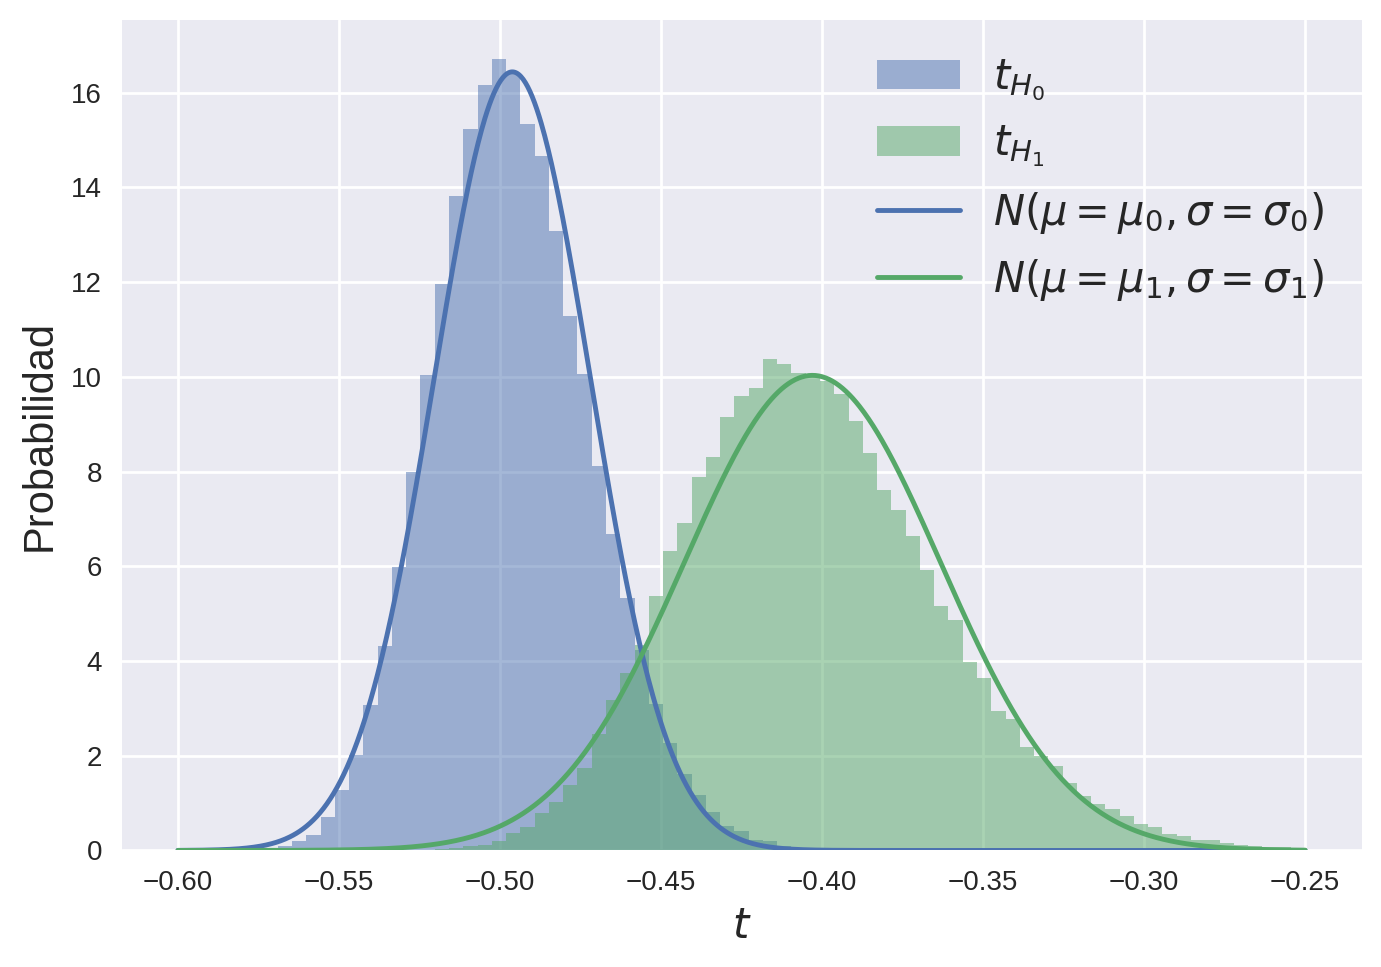

In [9]:
# Genero los bins a ojo
tmin, tmax = -0.6, -0.25
bins = np.linspace(tmin, tmax, 80)

# Grafico los histogramas
freq, bin_edges = np.histogram(t_h0, density=True, bins=bins)
plt.stairs(freq, bin_edges, fill=True, alpha=0.5, color="C0", label="$t_{H_0}$")
freq, bin_edges = np.histogram(t_h1, density=True, bins=bins)
plt.stairs(freq, bin_edges, fill=True, alpha=0.5, color="C1", label="$t_{H_1}$")

# Grafico sus distribuciones correspondientes
x = np.linspace(tmin, tmax, 1000)
plt.plot(x, ss.norm.pdf(x=x, loc=mu0, scale=np.sqrt(var0)),
        label="$N(\mu=\mu_0, \sigma=\sigma_0)$")
plt.plot(x, ss.norm.pdf(x=x, loc=mu1, scale=np.sqrt(var1)),
        label="$N(\mu=\mu_1, \sigma=\sigma_1)$")

plt.legend()
plt.ylabel("Probabilidad")
plt.xlabel("$t$")
plt.show()

Bueno, es casi cierto. Todavía se puede ver una asimetría que proviene de la distribución original de las variables. Esto sería cada vez menos notorio en cuanto aumente el número de datos en las muestras.

Ahora, para poder visualizar el error de tipo 1 y 2 primero tengo que calcular el valor crítico $t_C$ para el cual decido si un dato pertenece a una distribución o a la otra. Eso se hace usando la ecuación para $\alpha$ (EQ), que ahora gracias al estadístico que tomé se convierte en 

$$\alpha = \int_{t_C}^{\infty} f(t \mid H_0) dt$$

donde $f(t \mid H_0)$ es la función de distribución de $t$ dado que $H_0$ es cierto, que aproximé como la normal que grafiqué antes. Entonces puedo escribir $\alpha$ como 

$$\alpha = 0.05 = 1 - \int_{-\infty}^{t_C} N(t \mid \mu_0, \sigma_0) dt$$

donde puedo buscar el valor de esa integral usando la inversa de la CDF de esa normal de SciPy. Además calculo los otros valores relevantes

In [10]:
# Calculo tc
tc = ss.norm(mu0, np.sqrt(var0)).ppf(0.95)
print(f"El valor crítico es tc = {tc:.3f}")

# Error de tipo 1 lo definí yo con el alpha
print("El error de tipo 1 es alpha = 0.05")

# Error de tipo 2 
E2 = ss.norm(mu1, np.sqrt(var1)).cdf(tc)
print(f"El error de tipo 2 es beta = {E2:.3f}")

# Potencia
print(f"La potencia es P = {1 - E2:.3f}")

El valor crítico es tc = -0.456
El error de tipo 1 es alpha = 0.05
El error de tipo 2 es beta = 0.090
La potencia es P = 0.910


Con todo esto hago el gráfico que indica todas las zonas relevantes

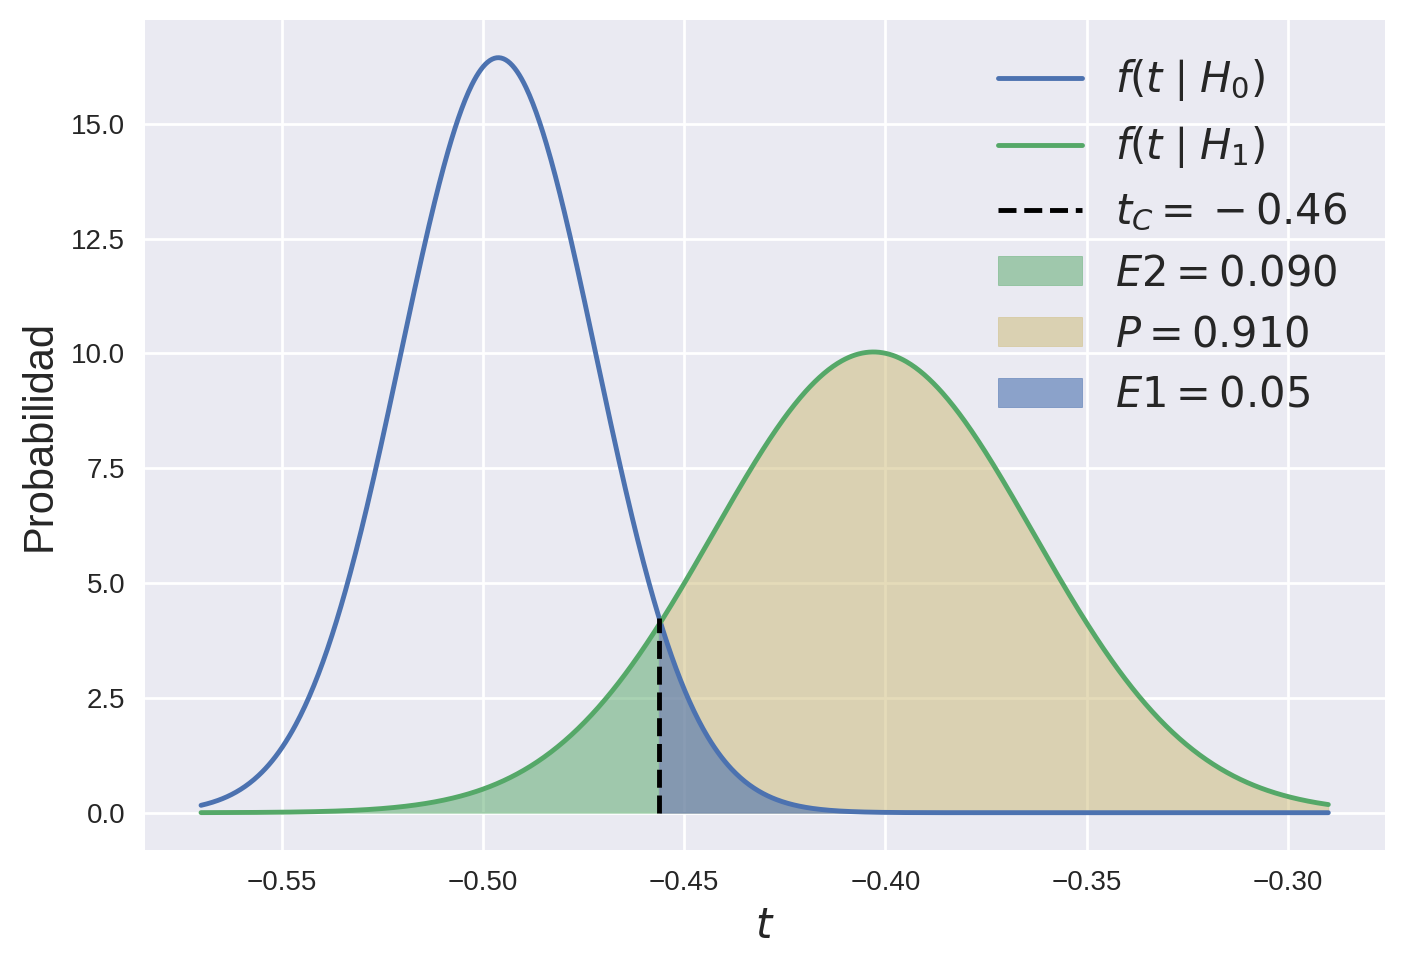

In [11]:

# Defino las rv de t0 y t1
n0, n1 = ss.norm(mu0, np.sqrt(var0)), ss.norm(mu1, np.sqrt(var1))

def plot_test():
    # Defino el rango del gráfico
    tmin, tmax = -0.57, -0.29
    t = np.linspace(tmin, tmax, 1000)

    # Grafico las PDF del estimador
    plt.plot(t, n0.pdf(t), label="$f(t \mid H_0)$")
    plt.plot(t, n1.pdf(t), label="$f(t \mid H_1)$")

    # Grafico el valor de tc
    plt.vlines(x=tc, ymin=0, ymax=max([n0.pdf(tc), n1.pdf(tc)]),
               ls="dashed", color="k", label=f"$t_C={tc:.2f}$")

    # Coloreo el área de error de tipo 2
    T2err = t[t <= tc]
    plt.fill_between(T2err, 0, n1.pdf(T2err), alpha=0.5,
                     label=f"$E2={E2:.3f}$", color="C1")

    # Coloreo la potencia
    P = t[t >= tc]
    plt.fill_between(P, 0, n1.pdf(P), alpha=0.5,
                     label=f"$P={1-E2:.3f}$", color="C4")

    # Coloreo el área de rechazo R (error de tipo 1)
    R = t[t >= tc]
    plt.fill_between(R, 0, n0.pdf(R), alpha=0.6,
                     label=f"$E1=0.05$", color="C0")

    plt.ylabel("Probabilidad")
    plt.xlabel("$t$")

plot_test()
plt.legend()
plt.show()

## Una resumida comparación

Este estadístico lo saqué de las condiciones que propone el lema de Neyman-Pearson (lo que supongo, pero no estoy seguro, quiere decir que es el mejor estadístico para hacer el test), pero no resulta para nada intuitivo. Está bueno hacer la comparación de qué pasaba si hubiese elegido un estadístico más común como el promedio. El valor de expectación de la $Weibull(\lambda, \alpha)$ es 

$$E[X] = \frac{1}{\lambda} \Gamma(1 + \frac{1}{\alpha})$$

que en nuestro caso es $E[X \mid \lambda = 1/30, \alpha = 1] = 30$ y $E[X \mid \lambda = 1/30, \alpha = 0.8] = 27.9$. Ahora genero cienmil realizaciones de este estadístico para ver sus histogramas en los casos en los que $H_0$ y $H_1$ son ciertas y compararlos con los histogramas del estadístico que usé antes.

In [12]:
t2_h0 = [np.mean(wbc.rvs(size=100)) for _ in range(N)]
t2_h1 = [np.mean(wbd.rvs(size=100)) for _ in range(N)]

Grafico los histogramas

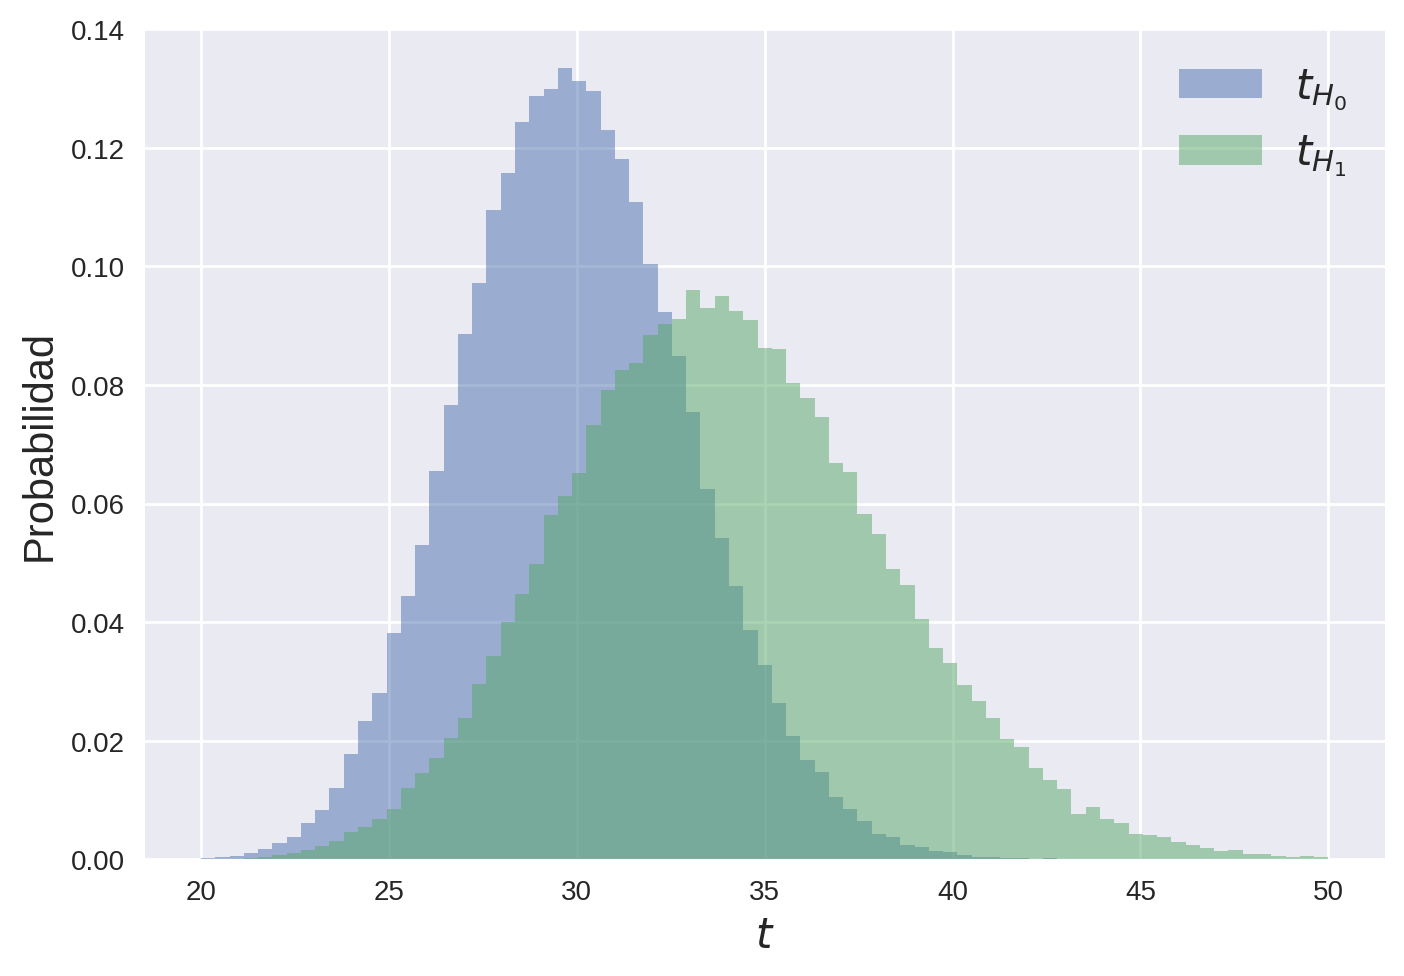

In [13]:
# Genero los bins a ojo
tmin, tmax = 20, 50
bins_mean = np.linspace(tmin, tmax, 80)

# Grafico los histogramas
freq, bin_edges = np.histogram(t2_h0, density=True, bins=bins_mean)
plt.stairs(freq, bin_edges, fill=True, alpha=0.5, color="C0", label="$t_{H_0}$")
freq, bin_edges = np.histogram(t2_h1, density=True, bins=bins_mean)
plt.stairs(freq, bin_edges, fill=True, alpha=0.5, color="C1", label="$t_{H_1}$")

plt.legend()
plt.ylabel("Probabilidad")
plt.xlabel("$t$")
plt.show()

Se ve claramente que este estadístico es mucho peor!

Como se solapan tanto las distribuciones, si fuera a hacer un test de hipótesis con estas distribuciones con $\alpha = 0.05$, el error de tipo 2 para este test sería mucho mayor que el anterior, y por lo tanto su potencia mucho menor. Obviamente siempre se puede mejorar el test aumentando la cantidad de mediciones, pero hacer un mejor test es gratis.

## Probando distintas significancias
#### Problema 5

Puedo hacer una función que me diga la potencia en función de alpha para las distribuciones de mi test, y no solo eso sino que también me puede decir el error de tipo 2 y el error de tipo 1

In [14]:
def calc_pot(alpha):
    tc = n0.ppf(1 - alpha)
    E2 = n1.cdf(tc)
    P = 1 - E2
    return P, E2

Grafico todo junto

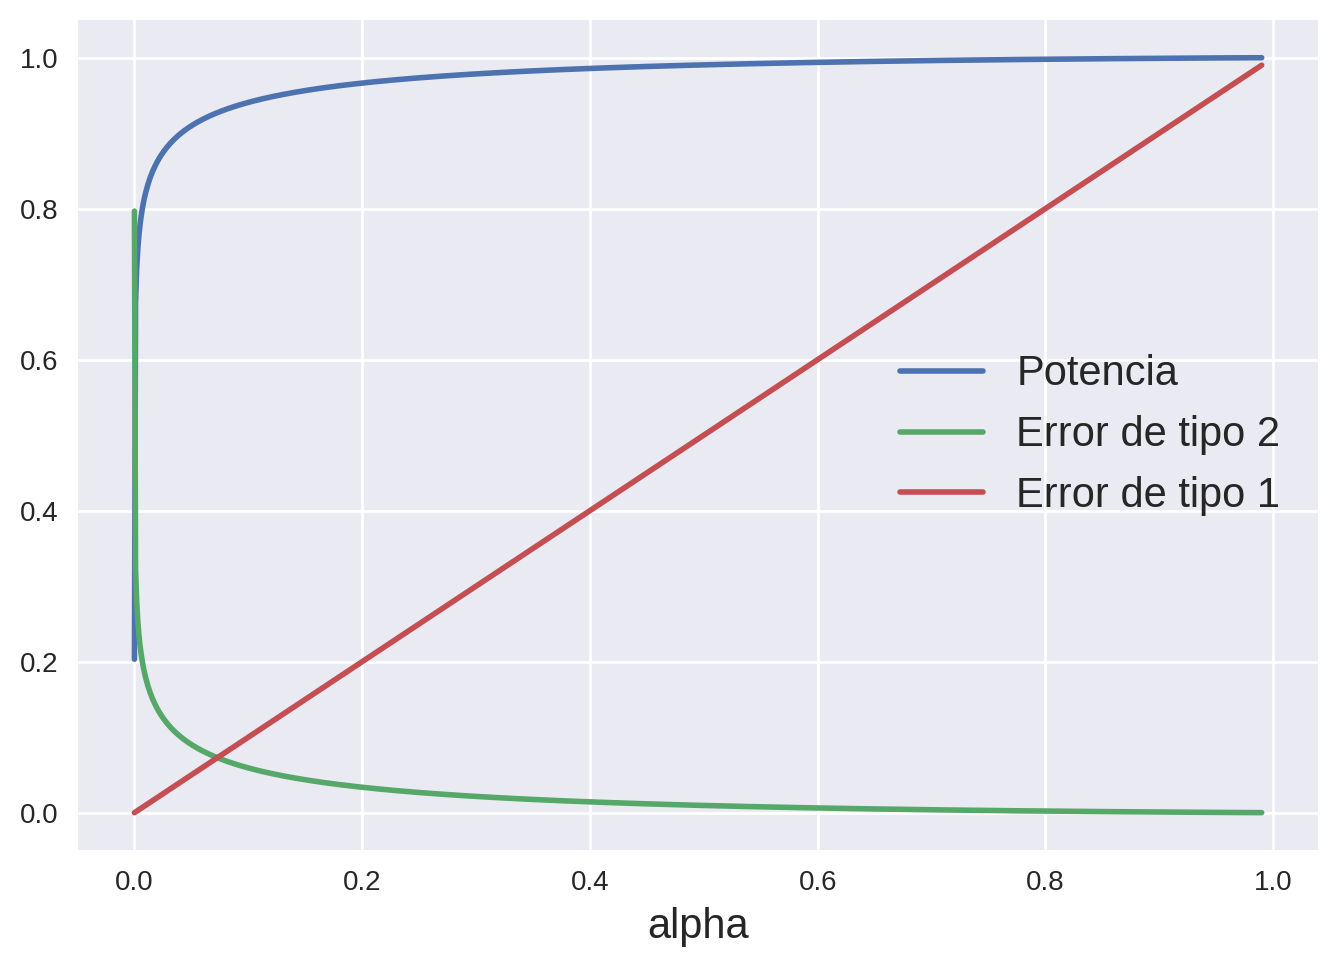

In [15]:
alphas = np.linspace(1e-7, 0.99, 1000)
p, e2 = calc_pot(alphas)
plt.plot(alphas, p, linewidth=2, 
         label="Potencia")
plt.plot(alphas, e2, linewidth=2,
         label="Error de tipo 2")
plt.plot(alphas, alphas, linewidth=2,
         label="Error de tipo 1")

plt.legend()
plt.xlabel("alpha")
plt.show()

Como la potencia crece muy rápido para los valores cercanos a $\alpha = 0$ se puede concluir que el test es bueno, ya que lo que se busca en un test de hipótesis es tener la mayor potencia para el menor $\alpha$ o error de tipo 1 posible.

## p-valor
#### Problemas 6 y 7

Dada una muestra puedo calcular su p-valor asociado. Para eso primero genero la muestra

In [16]:
sample = ss.weibull_min.rvs(0.9, size=100, scale=1/lmbd, loc=0)

y ahora calculo el estadístico $t_s$ asociado a la muestra

In [17]:
ts = estadistico(sample, lmbd, alpha0, alpha1) 

Puedo repetir el gráfico del test y agregarle el valor que obtuve con ésta muestra en particular. El p-valor será la integral $f(t \mid H_0)$ desde $t_s$ hasta infinito. La máxima/mínima significancia será 
$$\alpha = \int_{t_s}^{\infty} f(t \mid H_0) dt = 1 - \int_{-\infty}^{t_s} f(t \mid H_0) dt$$
que se puede calcular usando la CDF hasta $t_s$.

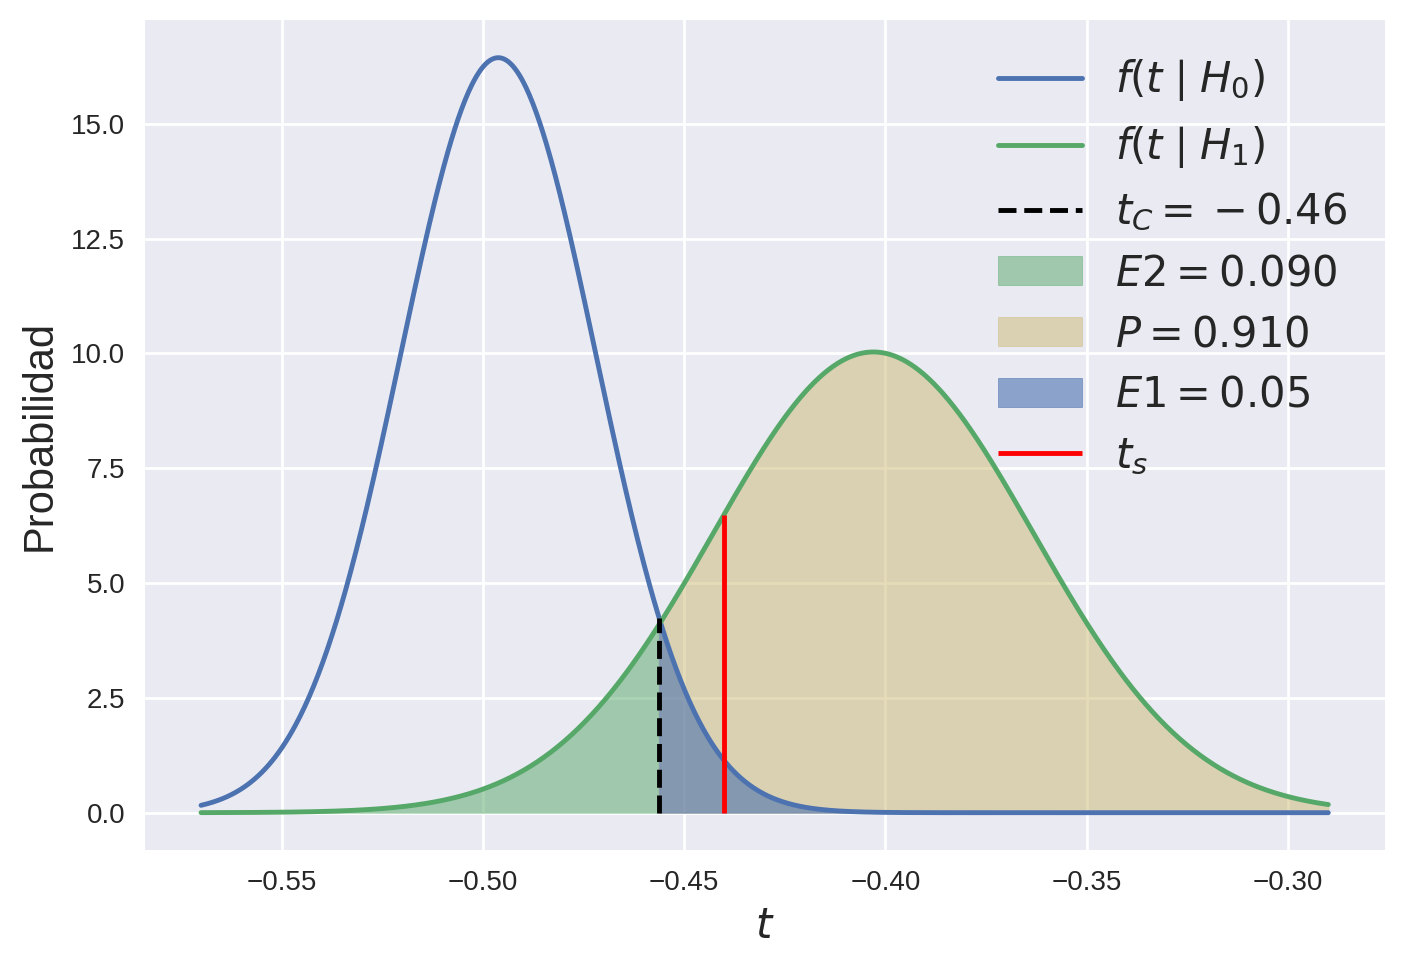

In [18]:
plot_test()
plt.vlines(x=ts, ymin=0, ymax=max(n0.pdf(ts), n1.pdf(ts)),
           color="red", label="$t_s$")
plt.legend()
plt.show()

Calculo la máxima significancia

In [19]:
max_alpha = 1 - n0.cdf(ts)
print(f"La máxima/mínima significancia es alpha = {max_alpha:.3f}")

La máxima/mínima significancia es alpha = 0.011


Repito el experimento anterior 1000 veces

In [20]:
ts_09 = [estadistico(ss.weibull_min.rvs(0.9, size=100, scale=1/lmbd, loc=0)
                       , lmbd, alpha0, alpha1) for _ in range(1000)]

Para visualizarlo ahora repito el gráfico del test pero agregándole un histograma de los estadísticos con $\alpha = 0.9$ que acabo de generar

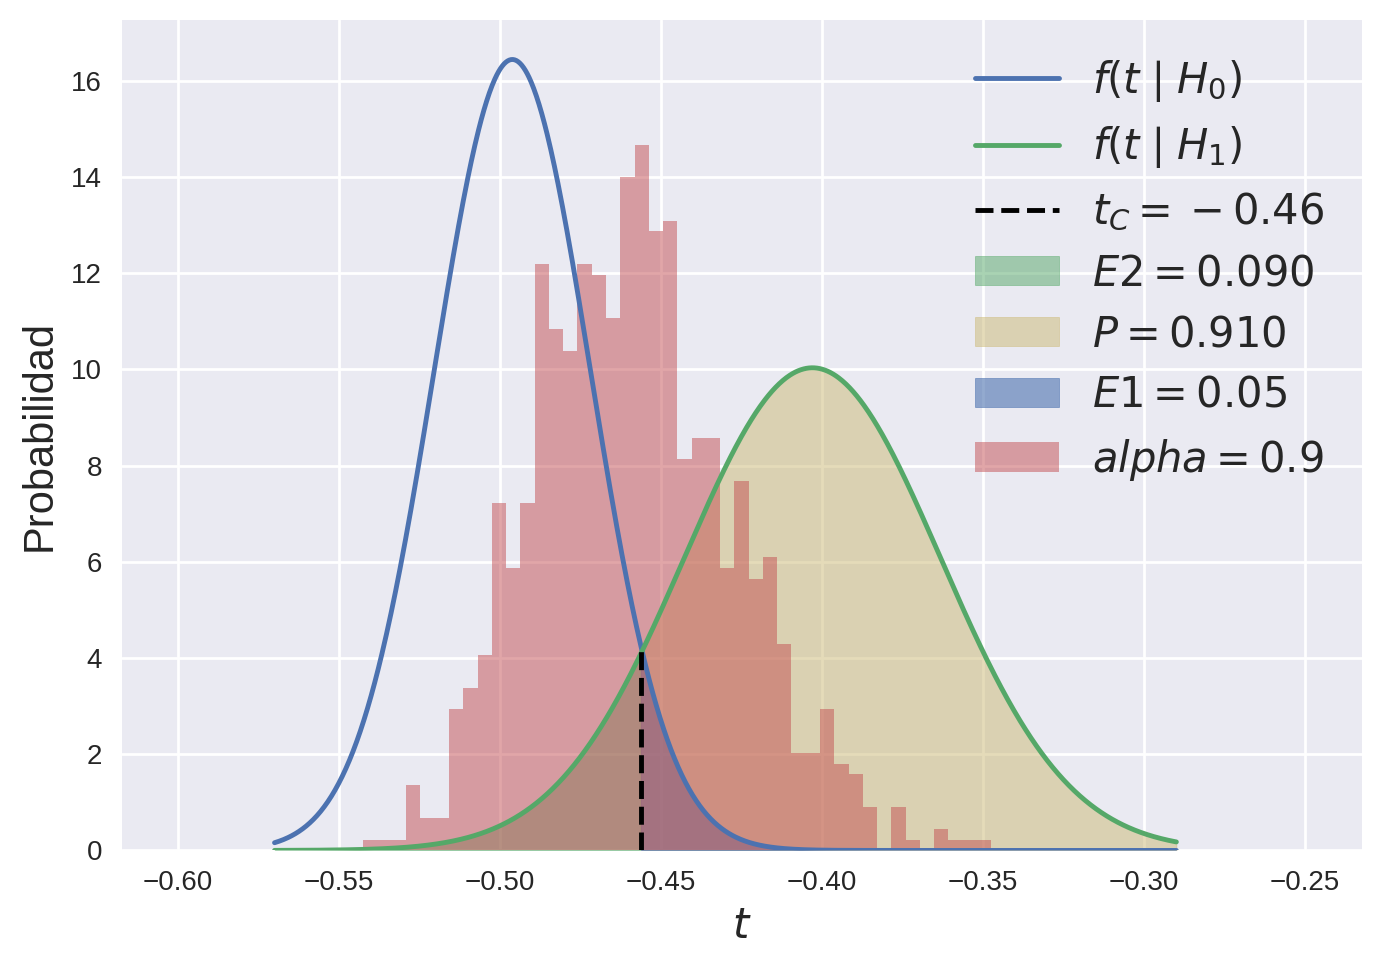

In [21]:
plot_test()

freq, bin_edges = np.histogram(ts_09, density=True, bins=bins)
plt.stairs(freq, bin_edges, fill=True, alpha=0.5, label="$alpha = 0.9$")
plt.legend()
plt.show()

A partir de todos esos estadísticos puedo calcular los p-values correspondientes igual que antes. También genero una lista de p-values similar pero para los cuales la hipótesis nula es cierta.

In [22]:
p_09 = [1 - n0.cdf(estadistico) for estadistico in ts_09]

# Genero 1000 estadísticos con H0 cierta
t_h0 = [estadistico(wbc.rvs(size=100), lmbd, 1, 0.8) for _ in range(1000)]
p_h0 = 1 - n0.cdf(t_h0)

Ahora grafico el histograma de ellos

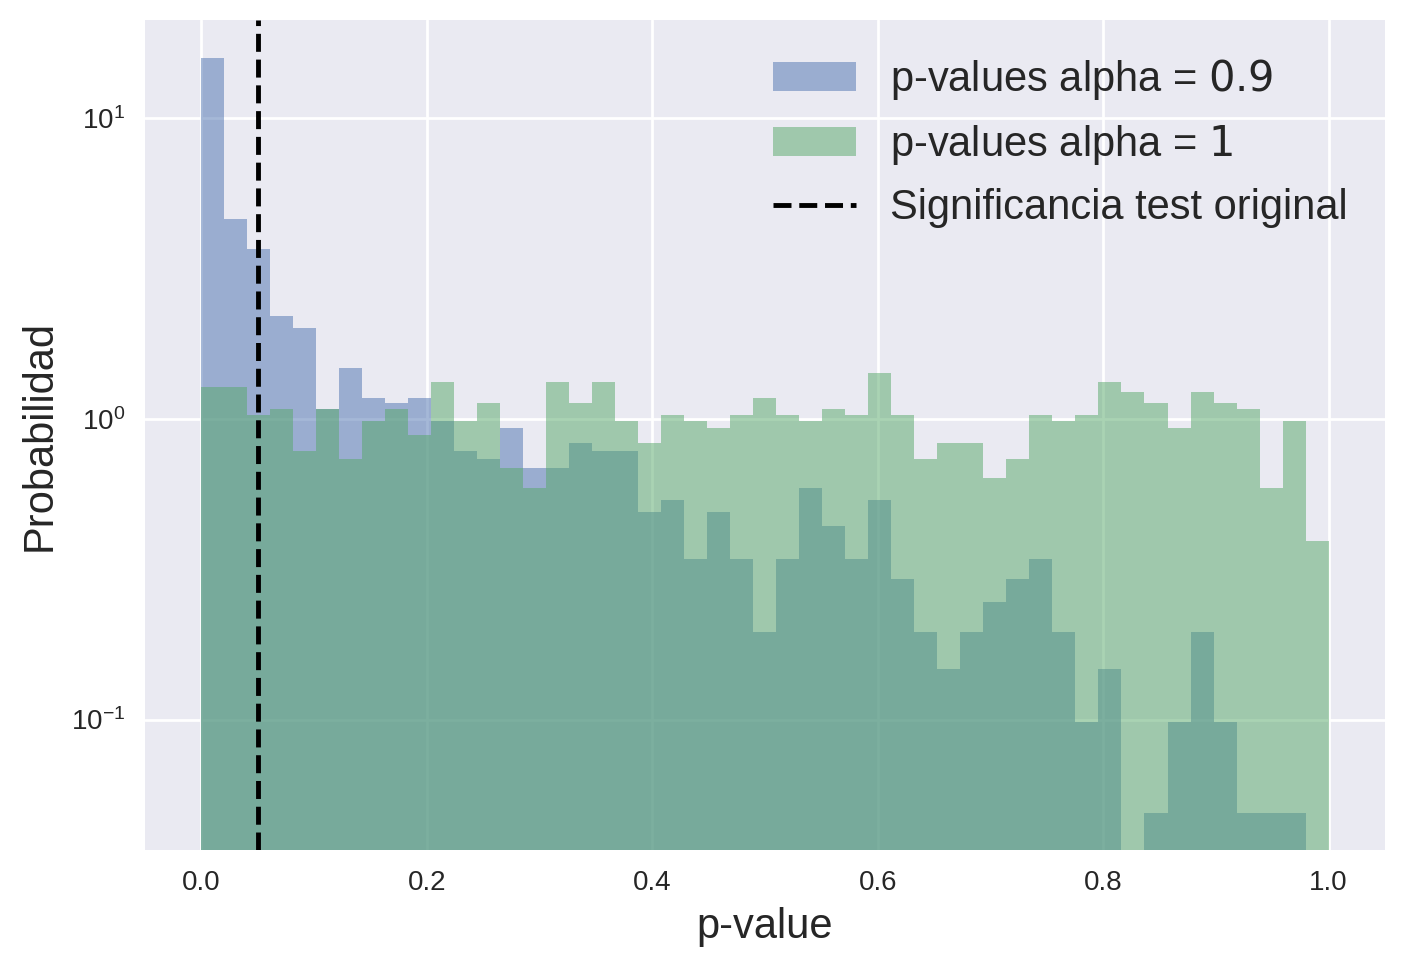

In [23]:
bins_01 = np.linspace(0, 1, 50)
freq, bin_edges = np.histogram(p_09, density=True, bins=bins_01)
plt.stairs(freq, bin_edges, fill=True, alpha=0.5, label="p-values alpha = $0.9$")
freq, bin_edges = np.histogram(p_h0, density=True, bins=bins_01)
plt.stairs(freq, bin_edges, fill=True, alpha=0.5, label="p-values alpha = $1$")
plt.axvline(0.05, ls="dashed", color="k", label="Significancia test original")
plt.legend()
plt.yscale("log")
plt.xlabel("p-value")
plt.ylabel("Probabilidad")
plt.show()

Lo que esperaba ver si la hipótesis nula fuera cierta es lo que se ve en el histograma verde: una distribución uniforme. Sin embargo se ve una distribución que decrece conforme el p-value aumenta.

Esto era fácil de ver en el gráfico anterior (ver figura FIG), donde el histograma de estadísticos para $\alpha = 0.9$ está corrido a la derecha. Por este motivo, va a haber muchos estadísticos que caigan en la cola derecha de la distribución correcta (la de $H_0$) y por lo tanto su p-valor (la integral $\int_{t_s}^\infty f(t \mid H_0) dt$) sea muy chico, y pocos en la cola izquierda para los cuales su p-valor sería grande. De hecho, si el $\alpha$ hubiese sido mayor a 1, la distribución azul sería al revés: mucho p-valores grandes y pocos chicos.

Cuando $H_0$ es cierta, la distribución de p-valores es uniforme porque si bien los estadísticos centrales a la distribución son más probables (es decir, los p-valores alrededor de 0.5 son más probables), también es ahí donde más varía la magnitud del p-valor. Estos dos efectos evidentemente se compensan para llegar a una distribución uniforme del p-valor.